## A net more sophisticated than LeNet
###  with cifar10 dataset

In [1]:
% matplotlib

Using matplotlib backend: TkAgg


In [2]:
% matplotlib inline

In [3]:
# coding=utf-8
# libraries & packages
import numpy
import math
import sys
from os import listdir
from os.path import isfile, join
from keras.utils import np_utils

# this function is provided from the official site
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

# from PIL import Image
# def ndarray2image (arr_data, image_fn):
#     img = Image.fromarray(arr_data, 'RGB')
#     img.save(image_fn)

from scipy.misc import imsave
def ndarray2image (arr_data, image_fn):
    imsave(image_fn, arr_data)

# set dataset path
dataset_path = './cifar_10/'

# define the information of images which can be obtained from official website
height, width, dim = 32, 32, 3
classes = 10

''' read training data '''
# get the file names which start with "data_batch" (training data)
train_fns = [fn for fn in listdir(dataset_path) if isfile(join(dataset_path, fn)) &
             fn.startswith("data_batch")]
# list sorting
train_fns.sort()

# make a glace about the training data
fn = train_fns[0]
raw_data = unpickle(dataset_path + fn)

# type of raw data
type(raw_data)
# output <type 'dict'>

# check keys of training data
raw_data_keys = raw_data.keys()
# output ['data', 'labels', 'batch_label', 'filenames']

# check dimensions of ['data']
raw_data['data'].shape
# (10000, 3072)

# concatenate pixel (px) data into one ndarray [img_px_values]
# concatenate label data into one ndarray [img_lab]
img_px_values = 0
img_lab = 0
for fn in train_fns:
    raw_data = unpickle(dataset_path + fn)
    if fn == train_fns[0]:
        img_px_values = raw_data['data']
        img_lab = raw_data['labels']
    else:
        img_px_values = numpy.vstack((img_px_values, raw_data['data']))
        img_lab = numpy.hstack((img_lab, raw_data['labels']))

# convert 1d-ndarray (0:3072) to 3d-ndarray(32,32,3)
X_train = numpy.asarray([numpy.dstack((r[0:(width*height)].reshape(height,width),
                                       r[(width*height):(2*width*height)].reshape(height,width),
                                       r[(2*width*height):(3*width*height)].reshape(height,width)
                                     )) for r in img_px_values])

Y_train = np_utils.to_categorical(numpy.array(img_lab), classes)

# draw one image from the pixel data
ndarray2image(X_train[0],"test_image.png")

# print the dimension of training data
print 'X_train shape:', X_train.shape
print 'Y_train shape:', Y_train.shape

''' read testing data '''
# get the file names which start with "test_batch" (testing data)
test_fns = [fn for fn in listdir(dataset_path) if isfile(join(dataset_path, fn)) & fn.startswith("test_batch")]

# read testing data
fn = test_fns[0]
raw_data = unpickle(dataset_path + fn)

# type of raw data
type(raw_data)

# check keys of testing data
raw_data_keys = raw_data.keys()
# ['data', 'labels', 'batch_label', 'filenames']

img_px_values = raw_data['data']

# check dimensions of data
print "dim(data)", numpy.array(img_px_values).shape
# dim(data) (10000, 3072)

img_lab = raw_data['labels']
# check dimensions of labels
print "dim(labels)",numpy.array(img_lab).shape
# dim(data) (10000,)

X_test = numpy.asarray([numpy.dstack((r[0:(width*height)].reshape(height,width),
                                      r[(width*height):(2*width*height)].reshape(height,width),
                                      r[(2*width*height):(3*width*height)].reshape(height,width)
                                    )) for r in img_px_values])

Y_test = np_utils.to_categorical(numpy.array(raw_data['labels']), classes)

# scale image data to range [0, 1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

# print the dimension of training data
print 'X_test shape:', X_test.shape
print 'Y_test shape:', Y_test.shape

# normalize inputs from 0-255 to 0.0-1.0

Using TensorFlow backend.


X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
dim(data) (10000, 3072)
dim(labels) (10000,)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [4]:
import tensorflow as tf
import numpy as np
import time

(32, 32, 3)


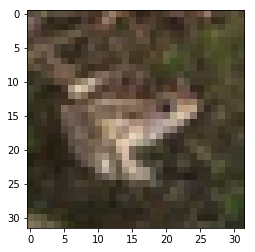

In [5]:
import matplotlib.pyplot as plt
print(X_train[0].shape)

idx = 22
plt.imshow(X_train[idx])
plt.show()

In [6]:
class sophi_net:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        self.image_holder = tf.placeholder(
                            tf.float32, shape=[self.batch_size, 32,32,3])
        self.label_holder = tf.placeholder(
                            tf.int32, shape=[self.batch_size, 10])
        
        self.one_image = tf.placeholder(
                            tf.float32, shape=[1,32,32,3])
        self.one_label = tf.placeholder(
                            tf.int32, shape=[1, 10]) 
        
#        self.logits = self.net()
         
        self.weight1, self.bias1= self.weight_with_loss([5,5,3,64],
                               stddev=5e-2, lamb=0.0, bias = 0.0 )
        kernel1 = tf.nn.conv2d(self.image_holder, self.weight1,
                               strides=[1,1,1,1], padding='SAME',
                               use_cudnn_on_gpu = True)
        self.conv1 = tf.nn.relu( tf.add(kernel1, self.bias1) ) 
        self.pool1 = tf.nn.max_pool(self.conv1, [1,3,3,1], 
                               strides=[1,2,2,1], padding='SAME')
        #norm1 = tf.nn.lrn(self.pool1,4,bias=1.0,alpha=1e-3/9.0,beta=0.75)
        
        
        # 2nd cnn layer
        self.weight2, self.bias2= self.weight_with_loss([5,5,64,64],
                               stddev=5e-2, lamb=0.0, bias = 0.1 )
        #kernel2 = tf.nn.conv2d(norm1, self.weight2, 
        kernel2 = tf.nn.conv2d(self.pool1, self.weight2, 
                               strides=[1,1,1,1], padding='SAME',
                               use_cudnn_on_gpu = True)
        self.conv2 = tf.nn.relu( tf.add(kernel2, self.bias2) ) 
        #norm2 = tf.nn.lrn(self.conv2,4,bias=1.0,alpha=1e-3/9.0,beta=0.75)
        #self.pool2 = tf.nn.max_pool(norm2, [1,3,3,1],
        self.pool2 = tf.nn.max_pool(self.conv2, [1,3,3,1],
                                strides=[1,2,2,1], padding='SAME')

        flatten = tf.reshape(self.pool2, [batch_size, -1])
        dim = flatten.get_shape()[1].value

        # 3rd fc layer
        self.weight3, self.bias3= self.weight_with_loss([dim,384],
                               stddev=0.04, lamb=0.004, bias = 0.1 )
        self.fc3 = tf.nn.relu(tf.add(tf.matmul(flatten, self.weight3),
                                self.bias3))

        # 4th fc layer
        self.weight4, self.bias4= self.weight_with_loss([384,192],
                               stddev=0.04, lamb=0.004, bias = 0.1 )
        self.fc4 = tf.nn.relu(tf.add(tf.matmul(self.fc3, self.weight4),
                                self.bias4))

        # 5th output logit layer
        self.weight5, self.bias5= self.weight_with_loss([192,10],
                               stddev=1/192.0, lamb=0.0, bias = 0.0 )
        self.logits = tf.add(tf.matmul(self.fc4, self.weight5), 
                             self.bias5)        
        
        self.VZ = self.net()

        
    def net(self,):
        # 1st cnn layer
        kernel1 = tf.nn.conv2d(self.one_image, self.weight1, 
                               strides=[1,1,1,1], padding='SAME')
        conv1 = tf.nn.relu( tf.add(kernel1, self.bias1) ) 
        pool1 = tf.nn.max_pool(conv1, [1,3,3,1], strides=[1,2,2,1],
                               padding='SAME')
        #norm1 = tf.nn.lrn(pool1,4,bias=1.0,alpha=1e-3/9.0,beta=0.75)
       
        # 2nd cnn layer
        #kernel2 = tf.nn.conv2d(norm1, weight2, strides=[1,1,1,1], padding='SAME',
        kernel2 = tf.nn.conv2d(pool1, self.weight2, strides=[1,1,1,1], padding='SAME',
                       use_cudnn_on_gpu = True)
        conv2 = tf.nn.relu( tf.add(kernel2, self.bias2) ) 
        #norm2 = tf.nn.lrn(conv2,4,bias=1.0,alpha=1e-3/9.0,beta=0.75)
        #pool2 = tf.nn.max_pool(norm2, [1,3,3,1], strides=[1,2,2,1], padding='SAME')
        pool2 = tf.nn.max_pool(conv2, [1,3,3,1], strides=[1,2,2,1], padding='SAME')

        
        flatten = tf.reshape(pool2, [batch_size, -1])
        dim = flatten.get_shape()[1].value

        # 3rd fc layer
        weight3, bias3= self.weight_with_loss([dim,384], stddev=0.04 ,
                                          lamb=0.004, bias = 0.1 )
        fc3 = tf.nn.relu(tf.add(tf.matmul(flatten, weight3) , bias3))

        # 4th fc layer
        weight4, bias4= self.weight_with_loss([384,192], stddev=0.04 ,
                                          lamb=0.004, bias = 0.1 )
        fc4 = tf.nn.relu(tf.add(tf.matmul(fc3, weight4) , bias4))

        # 5th output logit layer
        weight5, bias5= self.weight_with_loss([192,10], stddev=1/192.0 ,
                                          lamb=0.0, bias = 0.0 )
        logits = tf.add(tf.matmul(fc4, weight5) , bias5)
        sum_over_pool1 = tf.reduce_sum(pool1)
        gd1_op = tf.gradients(sum_over_pool1, conv1)
        sum_over_pool2 = tf.reduce_sum(pool2)
        gd2_op = tf.gradients(sum_over_pool2, conv2) 
        
        return [logits, kernel1, conv1, pool1, gd1_op,
                kernel2, conv2, pool2, gd2_op]

    def loss(self):
        labels = tf.cast(self.label_holder, tf.int64)
        cross_entropy_mean = tf.reduce_mean(
              tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,
              labels=self.label_holder, dim=-1, name='loss') )
        tf.add_to_collection('losses', cross_entropy_mean)                 
        return tf.add_n(tf.get_collection('losses'), name='total_loss')
                
    def weight_with_loss(self, shape, stddev, lamb, bias):
        weight_ = tf.Variable(tf.truncated_normal(shape, stddev = stddev))
        bias_ = tf.Variable(tf.constant(bias, shape=[shape[-1]]))
        weight_loss = tf.mul( lamb , tf.nn.l2_loss(weight_)  )
        tf.add_to_collection('losses', weight_loss)
        return weight_, bias_

In [7]:
#max_steps = 3000
batch_size = 128
model = sophi_net(batch_size)

In [8]:
cross_entropy = model.loss()
train_op = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
        #top_one_op = tf.nn.in_top_k(logits, label_holder, 1)

sess = tf.Session()
        #ini_op = tf.initialize_all_variables()
        #sess.run(ini_op)
sess.run(tf.initialize_all_variables())
#tf.train.start_queue_runners()

In [9]:
epochs = 10
num_samples = len(X_train)
perm = np.arange( num_samples )
num_samples_test = len(X_test)
perm_test = np.arange( num_samples_test )

for epoch in range(epochs):
    
    np.random.shuffle(perm)
    np.random.shuffle(perm_test)
    X_train = X_train[perm]
    Y_train = Y_train[perm]
    X_test = X_test[perm_test]
    Y_test = Y_test[perm_test]
    x_test = X_test[:batch_size]
    y_test = Y_test[:batch_size]
    
    start = 0 
    end = batch_size
    step = 0
    
    while end < num_samples:
        x_batch = X_train[start:end]
        y_batch = Y_train[start:end]
                
        sess.run(train_op, feed_dict={model.image_holder:x_batch,
                                      model.label_holder:y_batch})
        batch_loss = sess.run(cross_entropy,
                           feed_dict={model.image_holder:x_batch,
                                      model.label_holder:y_batch})
        test_loss = sess.run(cross_entropy,
                           feed_dict={model.image_holder:x_test,
                                      model.label_holder:y_test})
        
        if step%50 ==0:
            print(epoch, step, batch_loss, test_loss)
            
        
        start += batch_size
        end += batch_size
        step += 1

(0, 0, 6.3898249, 6.3979754)
(0, 50, 2.2947502, 2.3578002)
(0, 100, 1.8754941, 1.8296732)
(0, 150, 1.7684915, 1.721463)
(0, 200, 1.4336863, 1.5936258)
(0, 250, 1.6711789, 1.5777045)
(0, 300, 1.5129595, 1.4052124)
(0, 350, 1.4855456, 1.3707353)
(1, 0, 1.3073658, 1.5646598)
(1, 50, 1.3846025, 1.4411627)
(1, 100, 1.4509364, 1.4740494)
(1, 150, 1.2673652, 1.429816)
(1, 200, 1.310776, 1.5282578)
(1, 250, 1.275234, 1.2987339)
(1, 300, 1.2819833, 1.3447793)
(1, 350, 1.171948, 1.3781929)
(2, 0, 1.3944433, 1.4448724)
(2, 50, 1.1667447, 1.3931178)
(2, 100, 1.3796248, 1.3854524)
(2, 150, 1.2276783, 1.2935516)
(2, 200, 1.066718, 1.3432014)
(2, 250, 1.1369948, 1.1633132)
(2, 300, 1.1910036, 1.2096883)
(2, 350, 1.2581646, 1.2787964)
(3, 0, 1.1572915, 1.2205924)
(3, 50, 1.1924365, 1.2531418)
(3, 100, 1.2260021, 1.2838401)
(3, 150, 1.3096908, 1.2156341)
(3, 200, 1.0903424, 1.2975056)
(3, 250, 1.1023866, 1.3370051)
(3, 300, 0.94256121, 1.1724815)
(3, 350, 0.99702013, 1.1026415)
(4, 0, 1.0173466, 1.1690

In [10]:
correct_prediction = tf.equal(tf.argmax(model.logits,1), 
                              tf.argmax(model.label_holder,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
np.random.shuffle(perm_test)
X_test = X_test[perm_test]
Y_test = Y_test[perm_test]
x_test = X_test[:128]
y_test = Y_test[:128]
sess.run(accuracy, feed_dict={model.image_holder: x_test,
                              model.label_holder: y_test} )

0.7265625

In [12]:
###  vz_op contains: [logits, kernel1, conv1, pool1, gd1_op,
###                           kernel2, conv2, pool2, gd2_op]
vz_op = model.VZ

In [88]:
pic_idx = 77
x_vis = x_test[pic_idx].reshape([1,32,32,3])

(1, 8, 8, 64)
5
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)
(1, 16, 16, 64)


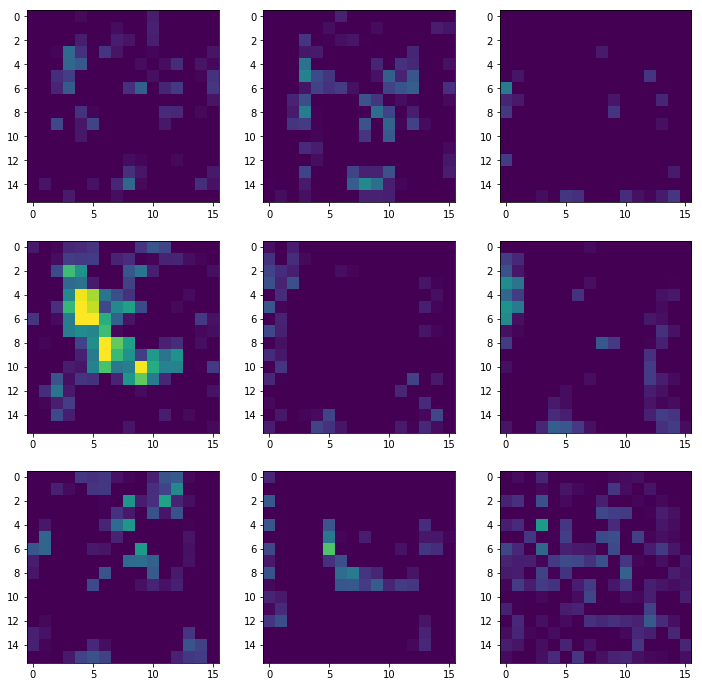

(1, 32, 32, 64)
(1, 32, 32, 64)
(1, 32, 32, 64)
(1, 32, 32, 3)


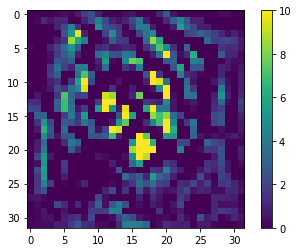

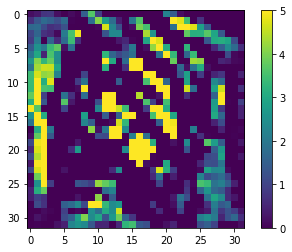

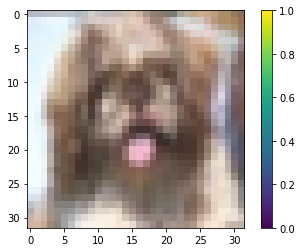

In [89]:
pool2 = sess.run(vz_op[7], feed_dict={model.one_image: x_vis } )

print(pool2.shape)             # should be (3, 8, 8, 64)
print(np.argmax(y_test[pic_idx]))  # make sure what the answer is 

#for ch in range(3):
#   plt.imshow(pool1[0,:,:,ch], clim=[0,2])
    #plt.imshow(pool1[0,:,:,ch],cmap='gray')
#    plt.colorbar()
#    plt.show()
    
gradient2 = sess.run(vz_op[8], feed_dict={model.one_image: x_vis}  )
gd2 = np.array(gradient2).reshape(1,16,16,64)
print(gd2.shape)

resized_pool2 = sess.run(tf.image.resize_images(pool2, [16, 16]))
print(resized_pool2.shape)

de_pool2 = resized_pool2*gd2
print(de_pool2.shape)

relu_de_pool2 = sess.run(tf.nn.relu(de_pool2) )
print(relu_de_pool2.shape)

deconv2 = sess.run(tf.nn.conv2d_transpose(relu_de_pool2, model.weight2,
                    output_shape =[1,16,16,64] , strides=[1,1,1,1],
                    padding = 'SAME'))

upper = 5
print(deconv2 .shape)


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
axes = axes.reshape(-1)
#print(axes[0])
for idx in range(9):
    axes[idx].imshow(deconv2[0,:,:,idx],clim=[0,upper])
plt.show()

#max_val2 = np.max(deconv2[0,:,:,0])
#reconst2 =  np.sign(deconv2[0,:,:,0]-0.1*(max_val2)  ) + 0.5


## ======================================================
gradient1 = sess.run(vz_op[4], feed_dict={model.one_image: x_vis}  )
gd1 = np.array(gradient1).reshape(1,32,32,64)

resized_pool1 = sess.run(tf.image.resize_images(deconv2, [32, 32]))
print(resized_pool1.shape)
#plt.imshow(resized_pool1[0,:,:,2],clim=[0,2])
#plt.colorbar()
#plt.show()

de_pool1 = resized_pool1*gd1
print(de_pool1.shape)

relu_de_pool1 = sess.run(tf.nn.relu(de_pool1) )
print(relu_de_pool1.shape)
#plt.imshow(relu_de_pool1[0,:,:,2],clim=[0,2])
#plt.colorbar()
#plt.show()

deconv1 = sess.run(tf.nn.conv2d_transpose(relu_de_pool1, model.weight1,
                    output_shape =[1,32,32,3] , strides=[1,1,1,1],
                    padding = 'SAME'))

flat1 = deconv1[0,:,:,0].reshape([-1])
flat2 = deconv1[0,:,:,1].reshape([-1])
flat3 = deconv1[0,:,:,2].reshape([-1])
bins = np.linspace(-0.1,1.1,20)

upper = 10
print(deconv1.shape)
plt.imshow(deconv1[0,:,:,0],clim=[0,upper])
plt.colorbar()
plt.show()

max_val1 = np.max(deconv1)
#reconst1 =  np.sign(deconv1[0,:,:,0]-0.1*(max_val1)  ) + 0.5


img = deconv1[0,:,:,:]
#plt.imshow(reconst1[:,:],clim=[0,3])
plt.imshow(deconv1[0,:,:,2],clim=[0,5])
plt.colorbar()
plt.show()

plt.imshow(x_vis[0],clim=[0,1])
plt.colorbar()
plt.show()

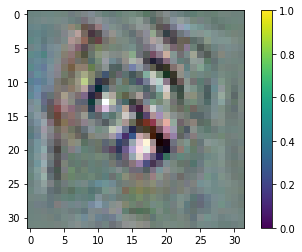

In [90]:
for idx in range(3):
    max_ = np.max(img[:,:,idx])
    min_ = np.min(img[:,:,idx])
    img[:,:,idx] = (img[:,:,idx]-min_ )/(max_ - min_ )
plt.imshow(img)
plt.colorbar()
plt.show()

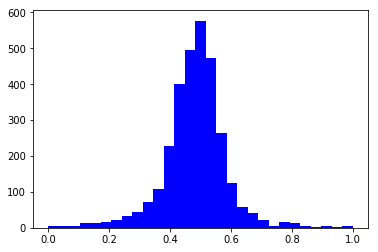

In [92]:
flat = deconv1.reshape(-1)
bins = np.linspace(np.min(flat), np.max(flat), 30)
plt.hist(flat, bins=bins, color = 'blue')
plt.show()

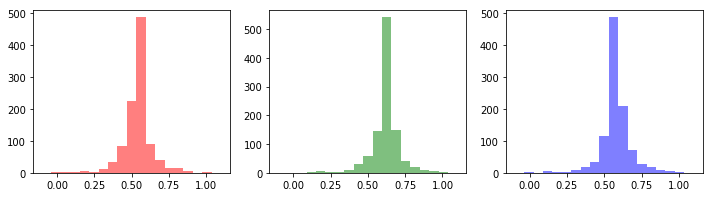

In [46]:
flat1 = img[:,:,0].reshape([-1])
flat2 = img[:,:,1].reshape([-1])
flat3 = img[:,:,2].reshape([-1])
bins = np.linspace(-0.1,1.1,20)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
axes = axes.reshape(-1)
#print(axes[0])
axes[0].hist(flat1, color='red', bins=bins, alpha=0.5,)
axes[1].hist(flat2, color='green', bins=bins, alpha=0.5,)
axes[2].hist(flat3, color='blue', bins=bins, alpha=0.5,)
plt.show()

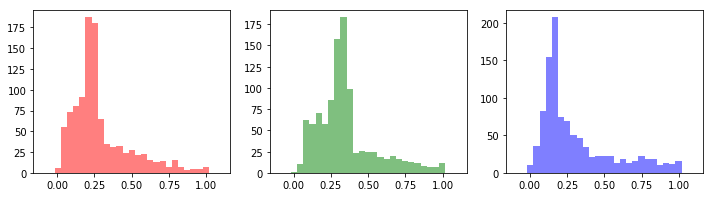

In [47]:
flat = x_vis[0].reshape([-1,3])
bins = np.linspace(-0.1,1.1,30)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
axes = axes.reshape(-1)
#print(axes[0])
axes[0].hist(flat[:,0], color='red', bins=bins, alpha=0.5,)
axes[1].hist(flat[:,1], color='green', bins=bins, alpha=0.5,)
axes[2].hist(flat[:,2], color='blue', bins=bins, alpha=0.5,)
plt.show()

In [334]:
x_vis[0].shape

(32, 32, 3)

In [50]:
optimizer = tf.train.AdamOptimizer(1e-3)
gd_and_w1 = optimizer.compute_gradients(cross_entropy,
            var_list=[model.weight1 ]) 
gd_and_w2 = optimizer.compute_gradients(cross_entropy,
            var_list=[model.weight2 ]) 
#train_step = optimizer.apply_gradients(gra_and_var)

In [51]:
gd_1 = sess.run(gd_and_w1, feed_dict = {model.image_holder:x_batch,
                                   model.label_holder:y_batch})
gd_2 = sess.run(gd_and_w2, feed_dict = {model.image_holder:x_batch,
                                   model.label_holder:y_batch})
print(np.array(gd_1).shape)
## gd_1[0][0] are gradients
## gd_1[0][1] are variables
print(gd_1[0][0][0][0][0][:4])
print(gd_2[0][0][0][0][0][:4])

(1, 2, 5, 5, 3, 64)
[-0.00486601 -0.01443334  0.02087443 -0.07131099]
[ -8.65501022e-07  -7.08983571e-05   2.50232959e-04  -6.85689622e-04]


In [29]:
#w1 = sess.run(model.weight1)

In [52]:
w1 = gd_1[0][1]
w1.shape

(5, 5, 3, 64)

In [53]:
w2 = gd_2[0][1]
w2.shape

(5, 5, 64, 64)

In [158]:
### layer1

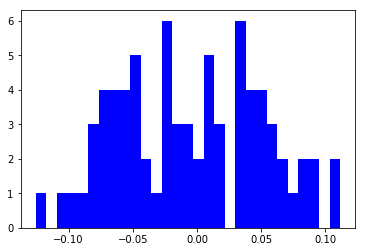

In [54]:
## plot w1 for one filter
which_filter = 1
flat_w1 = w1[:,:,:,which_filter].reshape(-1)
bins = np.linspace(np.min(flat_w1), np.max(flat_w1), 30)
plt.hist(flat_w1, bins=bins, color = 'blue')
plt.show()

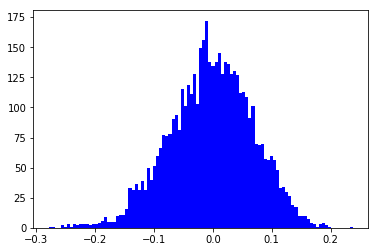

In [55]:
## plot w1 for all filter
flat_w1_all = w1.reshape(-1)
bins = np.linspace(np.min(flat_w1_all), np.max(flat_w1_all), 100)
plt.hist(flat_w1_all, bins=bins, color = 'blue')
plt.show()

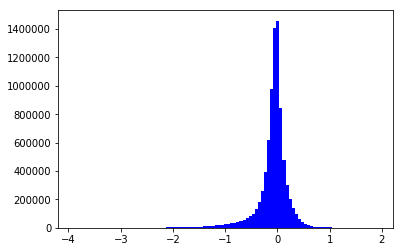

In [56]:
## plot kernel1 for all filter
k1_op = tf.nn.conv2d(model.image_holder, model.weight1,
                               strides=[1,1,1,1], padding='SAME',
                               use_cudnn_on_gpu = True)
k1 = sess.run(k1_op, feed_dict = {model.image_holder:x_batch })
flat_k1_all = k1.reshape(-1)
bins = np.linspace(np.min(flat_k1_all), np.max(flat_k1_all), 100)
plt.hist(flat_k1_all, bins=bins, color = 'blue')
plt.show()

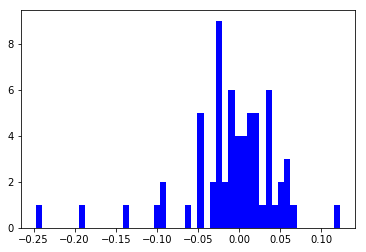

In [57]:
## plot b1 for all filter
b1 = sess.run(model.bias1)
flat_b1_all = b1.reshape(-1)
bins = np.linspace(np.min(flat_b1_all), np.max(flat_b1_all), 50)
plt.hist(flat_b1_all, bins=bins, color = 'blue')
plt.show()

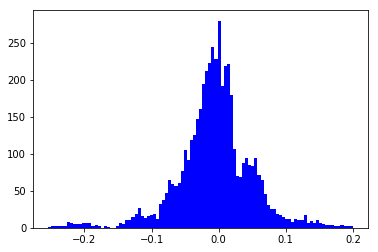

In [58]:
## plot gradients w.r.t. w1 for all filter
flat_gd1 = gd_1[0][0].reshape(-1)
bins = np.linspace(np.min(flat_gd1), np.max(flat_gd1), 100)
plt.hist(flat_gd1, bins=bins, color = 'blue')
plt.show()

In [ ]:
### layer2

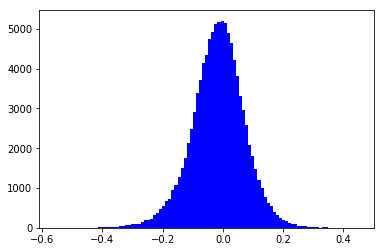

In [59]:
## plot w2 for all filter
flat_w2_all = w2.reshape(-1)
bins = np.linspace(np.min(flat_w2_all), np.max(flat_w2_all), 100)
plt.hist(flat_w2_all, bins=bins, color = 'blue')
plt.show()

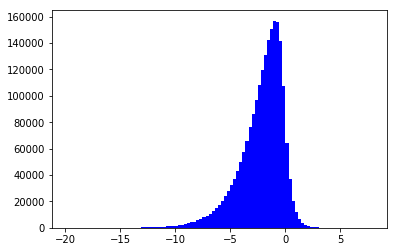

In [60]:
## plot kernel2 for all filter
k2_op = tf.nn.conv2d(model.pool1, model.weight2, 
                               strides=[1,1,1,1], padding='SAME',
                               use_cudnn_on_gpu = True)
k2 = sess.run(k2_op, feed_dict = {model.image_holder:x_batch })
flat_k2_all = k2.reshape(-1)
bins = np.linspace(np.min(flat_k2_all), np.max(flat_k2_all), 100)
plt.hist(flat_k2_all, bins=bins, color = 'blue')
plt.show()

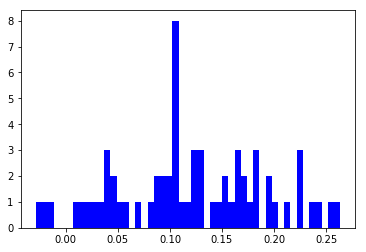

In [61]:
## plot b2 for all filter
b2 = sess.run(model.bias2)
flat_b2_all = b2.reshape(-1)
bins = np.linspace(np.min(flat_b2_all), np.max(flat_b2_all), 50)
plt.hist(flat_b2_all, bins=bins, color = 'blue')
plt.show()

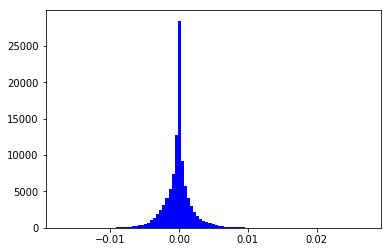

In [62]:
## plot gradients w.r.t. w2 for all filter
flat_gd2 = gd_2[0][0].reshape(-1)
bins = np.linspace(np.min(flat_gd2), np.max(flat_gd2), 100)
plt.hist(flat_gd2, bins=bins, color = 'blue')
plt.show()

In [44]:
feature2_1 = sess.run(model.conv2, feed_dict={model.image_holder:x_batch,
                                            model.label_holder:y_batch} )


In [45]:
feature2_2 = sess.run(model.pool2, feed_dict={model.image_holder:x_batch,
                                            model.label_holder:y_batch} )

### Note 1: pixel values in "deconvolved" picture is kinda multiplied by a large number.

In [ ]:
'''  posible reason:
       Y = M X    M is not square
     M'Y = M' M X
  (M' M)^(-1) M' Y = X
  1. if (M' M)^(-1) is approximately identity matrix I, then  M' Y = X
  2. if (M' M)^(-1) is approximately a*I, then  a*M' Y = X
''' 

## Appendix:

### 1. How tocompute gradients -two examples

In [ ]:
## use ".compute_gradients()"
y = tf.Variable(tf.truncated_normal([1]))
max_goal = tf.sin(y)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
gra_and_var = optimizer.compute_gradients(max_goal, var_list=[y])
#train_step = optimizer.apply_gradients(gra_and_var)
print(sess.run(y))
print(sess.run(gra_and_var))

In [378]:
## use ".gradients()"
x0 = X_train[0,:,:,:].reshape([1,32,32,3])
x_ = tf.placeholder(tf.float32,[1, 32, 32, 3])
y_ = tf.reduce_sum(tf.nn.max_pool(x_, [1, 2, 2, 1],
                      strides=[1,2,2,1] ,padding='SAME'), 
                   reduction_indices =[0,1]  )
gd_op = tf.gradients(y_, x_)
gradient = sess.run(gd_op, feed_dict={x_: x0} )

## shape of variable is [1, 32, 32, 3]
np.array(gradient).shape

### 2. Plot histogram -visualize activation/weight/gradient

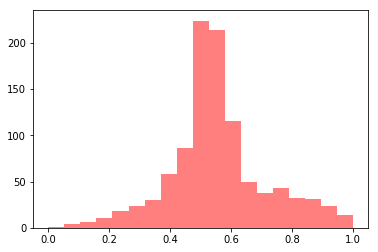

In [7]:
flat = X_train[0].reshape([-1,3])
bins = np.linspace(0,1,20)
plt.hist(flat[:,0], color='red', bins=bins, alpha=0.5,)
#plt.hist(flat[:,1], color='green', bins=bins, alpha=0.5,)
plt.show()

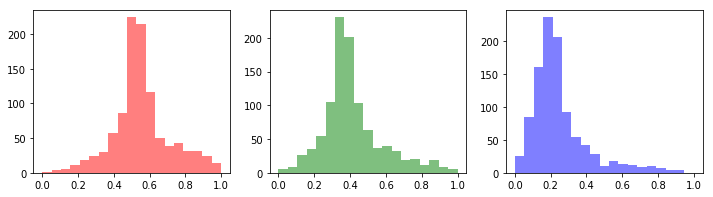

In [8]:
flat = X_train[0].reshape([-1,3])
bins = np.linspace(0,1,20)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
axes = axes.reshape(-1)
#print(axes[0])
axes[0].hist(flat[:,0], color='red', bins=bins, alpha=0.5,)
axes[1].hist(flat[:,1], color='green', bins=bins, alpha=0.5,)
axes[2].hist(flat[:,2], color='blue', bins=bins, alpha=0.5,)
plt.show()

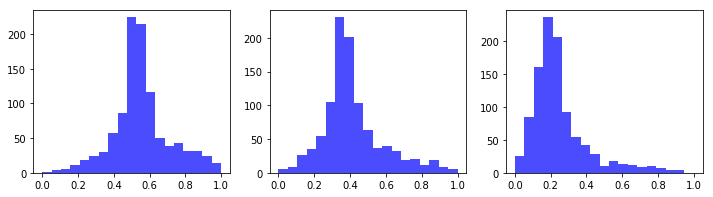

In [9]:
flat = X_train[0].reshape([-1,3])
bins = np.linspace(0,1,20)
channels = flat.shape[-1]

fig, axes = plt.subplots(nrows=1, ncols=channels, figsize=(12,3))
axes = axes.reshape(-1)
#print(axes[0])
#ylims = []
for c in range(channels):
    axes[c].hist(flat[:,c], color='blue', bins=bins, alpha=0.7,)
#    ylims.append(axes[c].get_ylim()  )
plt.show()
#ylims

### 3. Plot images: cv2 and pyplot

In [ ]:
import matplotlib.pyplot as plt
print(X_train[0].shape)
idx = 2
plt.imshow(X_train[idx])
plt.show()

In [5]:
import cv2
cv2.imshow('test',X_train[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

### 4. sophi-net blocks:

In [11]:
#def variable_with_weight_loss(shape, stddev, lamb, bias):
def weight_with_loss(shape, stddev, lamb, bias):
    weight_ = tf.Variable(tf.truncated_normal(shape, stddev = stddev))
    bias_ = tf.Variable(tf.constant(bias, shape=[shape[-1]]))
    weight_loss = tf.mul( lamb , tf.nn.l2_loss(weight_)  )
    tf.add_to_collection('losses', weight_loss)
    return weight_, bias_

In [36]:
### Total Loss:
def loss(logits, labels):
    labels = tf.cast(labels, tf.int64)
    cross_entropy_mean = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                labels=label_holder, dim=-1, name='loss') )
    tf.add_to_collection('losses', cross_entropy_mean)                 
    return tf.add_n(tf.get_collection('losses'), name='total_loss')

In [37]:
### Model:
image_holder = tf.placeholder(tf.float32, shape=[batch_size, 32,32,3])
label_holder = tf.placeholder(tf.int32, shape=[batch_size, 10])
weight1, bias1= weight_with_loss([5,5,3,64], stddev=5e-2 ,
                                          lamb=0.0, bias = 0.0 )
kernel1 = tf.nn.conv2d(image_holder, weight1, strides=[1,1,1,1], padding='SAME')
conv1 = tf.nn.relu( tf.add(kernel1, bias1) ) 
pool1 = tf.nn.max_pool(conv1, [1,3,3,1], strides=[1,2,2,1], padding='SAME')
norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=1e-3/9.0, beta=0.75)

    
weight2, bias2= weight_with_loss([5,5,64,64], stddev=5e-2 ,
                                          lamb=0.0, bias = 0.1 )
kernel2 = tf.nn.conv2d(norm1, weight2, strides=[1,1,1,1], padding='SAME',
                       use_cudnn_on_gpu = True)
conv2 = tf.nn.relu( tf.add(kernel2, bias2) ) 
norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=1e-3/9.0, beta=0.75)
pool2 = tf.nn.max_pool(norm2, [1,3,3,1], strides=[1,2,2,1], padding='SAME')

flatten = tf.reshape(pool2, [batch_size, -1])
dim = flatten.get_shape()[1].value

weight3, bias3= weight_with_loss([dim,384], stddev=0.04 ,
                                          lamb=0.004, bias = 0.1 )
fc3 = tf.nn.relu(tf.add(tf.matmul(flatten, weight3) , bias3))

weight4, bias4= weight_with_loss([384,192], stddev=0.04 ,
                                          lamb=0.004, bias = 0.1 )
fc4 = tf.nn.relu(tf.add(tf.matmul(fc3, weight4) , bias4))

weight5, bias5= weight_with_loss([192,10], stddev=1/192.0 ,
                                          lamb=0.0, bias = 0.0 )
logits = tf.add(tf.matmul(fc4, weight5) , bias5)

cross_entropy = loss(logits, label_holder)

train_op = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
#top_one_op = tf.nn.in_top_k(logits, label_holder, 1)

sess = tf.Session()
#ini_op = tf.initialize_all_variables()
#sess.run(ini_op)
sess.run(tf.initialize_all_variables())


#tf.train.start_queue_runners()
